In [1]:
import os
import numpy as np
import pandas as pd
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras.preprocessing import image as image_prepocessor


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data_path = "/home/paperspace/data/dogBreed/"
# data_path = r"D:\Projects\Datas\DogBreed"
im_size = 224

In [3]:
def read_img(img_id, training, size):
    if training == 'train':
        file_path = _training_image_loc
    else:
        file_path = _testing_image_loc
    img = image_prepocessor.load_img(os.path.join(file_path, '%s.jpg' % img_id), target_size=size)
    img = image_prepocessor.img_to_array(img)
#     img = preprocess_input(img)
    return img

In [4]:
_training_image_loc = os.path.join(data_path, "train")
_training_label_loc = os.path.join(data_path, "labels.csv")
_testing_image_loc = os.path.join(data_path, "test")
_sample_sub_loc = os.path.join(data_path, "sample_submission.csv")

In [5]:
df = pd.read_csv(_training_label_loc, index_col=0)
dog_breeds, labels = np.unique(df.values, return_inverse=True)
no_of_breeds = len(dog_breeds)
labels = labels.reshape(-1, 1)
encoder = OneHotEncoder()
labels = encoder.fit_transform(labels)

In [6]:
list_of_imgs = np.array([read_img(img_id, "train", (im_size, im_size)) for img_id in tqdm(df.index.values)])

100%|██████████| 10222/10222 [00:29<00:00, 342.12it/s]


In [7]:
X_train, X_valid, Y_train, Y_valid = train_test_split(list_of_imgs, labels, test_size=0.2)

print(Y_train.shape)

(8177, 120)


In [8]:
X_train.shape

(8177, 224, 224, 3)

In [9]:
X_train[0, :, :, 0]

array([[236., 236., 236., ..., 206., 225., 234.],
       [237., 236., 236., ..., 206., 225., 234.],
       [239., 237., 236., ..., 206., 225., 234.],
       ...,
       [160.,  53., 138., ..., 101., 146., 145.],
       [173.,  95.,  88., ..., 122., 183., 117.],
       [161., 168., 114., ..., 144., 189., 102.]], dtype=float32)

In [10]:
model = ResNet50(include_top=False, weights='imagenet')
bottleneck_features_train = model.predict(X_train)
# np.save("temp_train.npy", bottleneck_features_train)

bottleneck_features_val = model.predict(X_valid)
# np.save("temp_val.npy", bottleneck_features_val)  
bottleneck_features_val.shape

(2045, 1, 1, 2048)

In [11]:
# btl_shape = bottleneck_features_train.shape
# bottleneck_features_train = bottleneck_features_train.reshape(btl_shape[0], 1, 1, btl_shape[-1])

# btl_shape = bottleneck_features_val.shape
# bottleneck_features_val = bottleneck_features_val.reshape(btl_shape[0], 1, 1, btl_shape[-1])

# # (2045, 1, 1, 2048)


In [ ]:
model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
model.add(Dense(2048, activation="relu"))
# model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.8))
model.add(Dense(120, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(bottleneck_features_train, Y_train, epochs=50, batch_size=60,
                   validation_data=(bottleneck_features_val, Y_valid))

Train on 8177 samples, validate on 2045 samples
Epoch 1/50
8177/8177 [==============================] - 2s 246us/step - loss: 4.4438 - acc: 0.0859 - val_loss: 3.0010 - val_acc: 0.3325
Epoch 2/50
8177/8177 [==============================] - 1s 124us/step - loss: 3.3415 - acc: 0.1853 - val_loss: 2.3661 - val_acc: 0.4181
Epoch 3/50
8177/8177 [==============================] - 1s 124us/step - loss: 2.9348 - acc: 0.2535 - val_loss: 2.1045 - val_acc: 0.4699
Epoch 4/50
8177/8177 [==============================] - 1s 124us/step - loss: 2.7361 - acc: 0.2802 - val_loss: 1.9195 - val_acc: 0.4817
Epoch 5/50
8177/8177 [==============================] - 1s 122us/step - loss: 2.6010 - acc: 0.3087 - val_loss: 1.8277 - val_acc: 0.4958
Epoch 6/50
8177/8177 [==============================] - 1s 123us/step - loss: 2.4882 - acc: 0.3307 - val_loss: 1.8104 - val_acc: 0.5037
Epoch 7/50
8177/8177 [==============================] - 1s 122us/step - loss: 2.3907 - acc: 0.3559 - val_loss: 1.7134 - val_acc: 0.5340


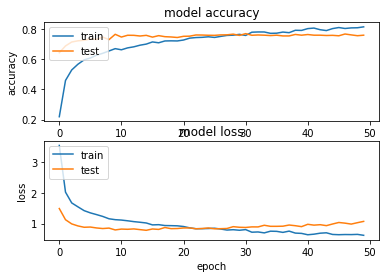

In [13]:
plt.figure(1)  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

In [10]:
from keras.applications.inception_v3 import InceptionV3
model = InceptionV3(include_top=False, weights='imagenet')

In [11]:
# model = ResNet50(include_top=False, weights='imagenet')
bottleneck_features_train = model.predict(X_train)
# np.save("temp_train.npy", bottleneck_features_train)

bottleneck_features_val = model.predict(X_valid)
# np.save("temp_val.npy", bottleneck_features_val)  
bottleneck_features_val.shape

(2045, 5, 5, 2048)

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
model.add(Dense(2048, activation="relu"))
# model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.8))
model.add(Dense(120, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(bottleneck_features_train, Y_train, epochs=50, batch_size=60,
                   validation_data=(bottleneck_features_val, Y_valid))

Train on 8177 samples, validate on 2045 samples
Epoch 1/50
8177/8177 [==============================] - 16s 2ms/step - loss: 15.9633 - acc: 0.0095 - val_loss: 15.9841 - val_acc: 0.0083
Epoch 2/50
8177/8177 [==============================] - 13s 2ms/step - loss: 15.9604 - acc: 0.0098 - val_loss: 15.9841 - val_acc: 0.0083
Epoch 3/50
 480/8177 [>.............................] - ETA: 12s - loss: 15.8830 - acc: 0.0146